In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse
import datetime
import importlib
import os
import tensorflow as tf
import yaml
import math
from train_utils import *

In [2]:
     , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
file_address = open('config/scenenet/test/depth_diffloss2.config')
config = yaml.load(file_address)

/nethome/shickson3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
tf.reset_default_graph()
module = importlib.import_module('models.' + config['model'])
model_func = getattr(module, config['model'])
helper = get_dataset(config)
modality_infos, num_label_classes = extract_modalities(config)
data_list, iterator = helper.get_test_data(config, num_label_classes)
resnet_name = 'resnet_v2_50'

aux_loss_mode = 'true'
if 'aux_loss_mode' in config:
    aux_loss_mode = config['aux_loss_mode'].lower()
with tf.variable_scope(resnet_name):
    model = model_func(modality_infos=modality_infos, aux_loss_mode=aux_loss_mode, training=False)
    images_pl, depths_pl, normals_pl, labels_pl, update_ops = setup_model(model, config, train=False)

config1 = tf.ConfigProto()
config1.gpu_options.allow_growth = True
sess = tf.Session(config=config1)
sess.run(tf.global_variables_initializer())
import_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
print 'total_variables_loaded:', len(import_variables)
saver = tf.train.Saver(import_variables)
saver.restore(sess, config['checkpoint'])

W1007 12:08:43.417036 140636942300928 deprecation.py:323] From dataset/helper.py:111: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W1007 12:08:43.740139 140636942300928 deprecation.py:323] From dataset/helper.py:129: make_one_shot_iterator (from tensorflow.python.data.

Network_Construction


W1007 12:09:09.131587 140636942300928 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1007 12:09:09.222805 140636942300928 deprecation_wrapper.py:119] From models/network_base.py:113: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1007 12:09:10.901711 140636942300928 deprecation.py:506] From models/network_base.py:252: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1007 12:09:11.407149 140636942300928 deprecation_wrapper.py:119] From mod

total_variables_loaded: 383


W1007 12:09:15.925996 140636942300928 deprecation.py:323] From /nethome/shickson3/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [4]:
feed_dict = setup_feeddict(data_list, sess, images_pl, depths_pl, normals_pl, labels_pl, config)

In [12]:
inputs = dict()
for mod in config['output_modality']:
    if mod == 'labels':
        inputs[mod] = model.softmax
    elif mod == 'normals':
        inputs[mod] = model.output_normals
    elif mod == 'depth':
        inputs[mod] = model.output_depth * 1000
        #inputs['depth_input'] = colorize(tf.cast(depths_pl, tf.float32), cmap='jet')
results = sess.run(list(inputs.values()), feed_dict=feed_dict)
for mod, result in zip(list(inputs.keys()), results):
    if mod == 'labels':
        labels_matrix = get_label_metrics(result, feed_dict, labels_pl, labels_matrix)
    elif mod == 'normals':
        normals_matrix = compute_normals_matrix(feed_dict[normals_pl], result, feed_dict[depths_pl], normals_matrix)

#total_num += config['batch_size']

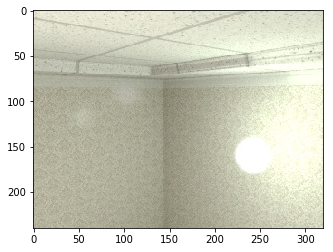

In [13]:
t = 0
rgb = feed_dict[images_pl]
test_rgb = (rgb[t,...]).astype(np.uint8)
plt.imshow(test_rgb)

(240, 320)


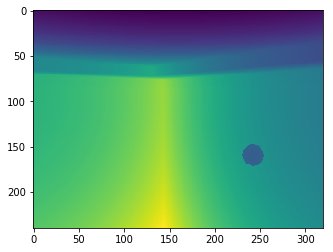

In [14]:
depths = feed_dict[depths_pl]
gt_depth = depths[t,:,:,:].reshape((240,320))
print gt_depth.shape
plt.imshow(gt_depth)

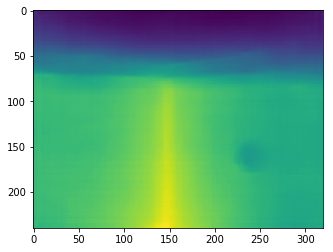

In [41]:
pred_depth = results[0]
plt.imshow(pred_depth.reshape((240,320)))

In [61]:
def compute_rmse(predictions, labels):
    return np.sqrt(((predictions - labels) ** 2).mean(axis=-1))

def compute_rel_error(pred, labels):
    return (np.abs(pred - labels) / pred).mean(axis=-1)

def compute_depth_matrix(depth_gt, pred, depth_matrix):
    pred_squeezed = np.squeeze(pred)
    depth_gt_squeezed = np.squeeze(depth_gt)
    weights = ~(depth_gt_squeezed == 0)
    num_weights = float(np.sum(weights))
    dist = np.maximum(depth_gt_squeezed / pred_squeezed, pred_squeezed / depth_gt_squeezed)
    masked_dist = dist[weights]
    below_1 = np.sum(masked_dist <= 1.25) / num_weights
    below_2 = np.sum(masked_dist <= 1.5625) / num_weights
    below_3 = np.sum(masked_dist <= 1.953124) / num_weights
    rmse_val = compute_rmse(pred_squeezed[weights], depth_gt_squeezed[weights]) / 1000.0
    rel_error = compute_rel_error(pred_squeezed[weights], depth_gt_squeezed[weights])
    depth_matrix += np.array([below_1, below_2, below_3, rmse_val, rel_error])
    return depth_matrix


In [62]:
depth_matrix = np.zeros((5))
depth_matrix = compute_depth_matrix(depths, pred_depth, depth_matrix)
print depth_matrix

[0.99429687 1.         1.         0.2949816  0.0749125 ]


In [54]:
print np.min(depths)
print np.max(depths)
print np.min(pred_depth)
print np.max(pred_depth)

1178.0
5128.0
1295.7899
4653.88


In [60]:
print sqrt(mean_squared_error(np.squeeze(depths), np.squeeze(pred_depth))) / 1000
print sqrt(mean_squared_error(np.squeeze(depths / 1000), np.squeeze(pred_depth / 1000)))

0.294981593705
0.29498159044
